# 3D CNN over 11x11 single-station-sub-rasters

In [1]:
import numpy as np
import pandas as pd
import rasterio as rio
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import glob 
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

## 1. load Data

In [2]:
data_drive = r'F:/'

In [3]:
stammdaten = pd.read_excel(data_drive +r'GruV-Net/data/Stammdaten_HE.xlsx')
stammdaten.set_index('Proj_ID', inplace=True)
gw_weekly = pd.read_csv(data_drive +r'GruV-Net/data/groundwater_levels_preprocessed_hesse/weekly/gw_lvl_complete.csv')
gw_weekly.set_index('Datum', inplace=True)

In [4]:
rws_folder = data_drive + r'GruV-Net/data/precipitation/weekly-sum/GTiff/'

rws_files_paths = glob.glob(rws_folder+'*2013*.tif') + glob.glob(rws_folder+'*2014*.tif') + glob.glob(rws_folder+'*2015*.tif') + glob.glob(rws_folder+'*2016*.tif') + glob.glob(rws_folder+'*2017*.tif')
rws_files_paths.sort()
rws_files = list(map(os.path.basename, rws_files_paths))

In [5]:
def assemble_instances(files, file_paths):
    x_regnie = []
    x_gw = []
    y = []

    for i in range(0, len(files)-11):
        srcs =  []
        for l in range(0,12):
            srcs.append(rio.open(file_paths[i+l]))
        stations = gw_weekly.loc[ files[i][4:14] , : ].dropna().index.tolist()
        for s in stations:
            instance_regnie = np.ndarray(shape=(12,11,11,1))
            east = stammdaten.loc[s]['OSTWERT']
            north = stammdaten.loc[s]['NORDWERT']
            row, col = srcs[0].index(east, north)
            # das ist noch ein Problem, manche Stationen zu nah am Rand
            try:
                for j in range(12):
                    r = srcs[j].read(1, window=rio.windows.Window(col-5, row-5, 11, 11))
                    instance_regnie[j] = r.reshape((11,11,1))
            except ValueError:
                continue

            instance_gw = []
            try:    
                for k in [0, 4, 8]:
                    #lieber in Prozent?
                    change =  gw_weekly.loc[files[i+k+4][4:14], : ][s] - gw_weekly.loc[files[i+k][4:14], : ][s]
                    if np.isnan(change):
                        raise Exception()
                    else: instance_gw = np.append(instance_gw, change)
            except Exception:
                continue 

            x_regnie.append(instance_regnie)
            x_gw.append(instance_gw[:2])
            y = y + list(instance_gw[2:])
    return np.array(x_regnie), np.array(x_gw), np.array(y)

In [6]:
X_regnie, X_gw, y = assemble_instances(rws_files, rws_files_paths)

In [7]:
print(X_regnie.shape)
print(X_gw.shape)
print(y.shape)

(104423, 12, 11, 11, 1)
(104423, 2)
(104423,)


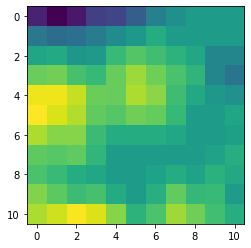

In [8]:
plt.imshow(X_regnie[0][0].reshape((11,11)))

## 2. Define and train CNN

In [18]:
regnie_input = keras.Input(shape=(12, 11, 11, 1), name="regnie")
gw_input = keras.Input(shape=(2), name="gw")

regnie_features = layers.Conv3D(64, 3, data_format='channels_last')(regnie_input)
regnie_features = layers.MaxPooling3D(pool_size=(3))(regnie_features)
regnie_features = layers.Flatten()(regnie_features)
x = layers.concatenate([regnie_features, gw_input])
x = layers.Dense(64)(x)
pred = layers.Dense(1)(x)

GruV = keras.Model(
    inputs=[regnie_input, gw_input],
    outputs=[pred],
)

![Model Architecture](img/Model-Archtitecture_02-07-20.png)

In [10]:
X_regnie_train, X_regnie_test, y_train, y_test = train_test_split(X_regnie, y, test_size=0.2, shuffle=False)
X_gw_train, X_gw_test = train_test_split(X_gw, test_size=0.2, shuffle=False)

In [19]:
print(X_regnie_train.shape)
print(X_regnie_test.shape)
print(X_gw_train.shape)
print(X_gw_test.shape)
print(y_train.shape)
print(y_test.shape)

(83538, 12, 11, 11, 1)
(20885, 12, 11, 11, 1)
(83538, 2)
(20885, 2)
(83538,)
(20885,)


In [12]:
regnie_scaler = preprocessing.StandardScaler().fit(X_regnie_train.reshape(*X_regnie_train.shape[:1], -1))
gw_scaler = preprocessing.MaxAbsScaler().fit(X_gw_train)

In [13]:
X_regnie_train = regnie_scaler.transform(X_regnie_train.reshape(*X_regnie_train.shape[:1], -1)).reshape((83538, 12, 11, 11, 1))
X_regnie_test = regnie_scaler.transform(X_regnie_test.reshape(*X_regnie_test.shape[:1], -1)).reshape((20885, 12, 11, 11, 1))

In [14]:
X_gw_train = gw_scaler.transform(X_gw_train)
X_gw_test = gw_scaler.transform(X_gw_test)

In [20]:
GruV.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error',tf.keras.metrics.RootMeanSquaredError()])
GruV.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
regnie (InputLayer)             [(None, 12, 11, 11,  0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 10, 9, 9, 64) 1792        regnie[0][0]                     
__________________________________________________________________________________________________
max_pooling3d_1 (MaxPooling3D)  (None, 3, 3, 3, 64)  0           conv3d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 1728)         0           max_pooling3d_1[0][0]            
____________________________________________________________________________________________

In [21]:
GruV.fit(
    {"regnie": X_regnie_train, "gw": X_gw_train},
    y_train,
    epochs=20,
    validation_data=({"regnie": X_regnie_test, "gw": X_gw_test}, y_test)
)


Train on 83538 samples, validate on 20885 samples
Epoch 1/20
83538/83538 [==============================] - 16s 188us/sample - loss: 0.4360 - mean_absolute_error: 0.3044 - root_mean_squared_error: 0.6603 - val_loss: 0.4497 - val_mean_absolute_error: 0.3210 - val_root_mean_squared_error: 0.6706
Epoch 2/20
83538/83538 [==============================] - 14s 173us/sample - loss: 0.4163 - mean_absolute_error: 0.2985 - root_mean_squared_error: 0.6452 - val_loss: 0.4037 - val_mean_absolute_error: 0.2259 - val_root_mean_squared_error: 0.6354
Epoch 3/20
83538/83538 [==============================] - 14s 173us/sample - loss: 0.4149 - mean_absolute_error: 0.2949 - root_mean_squared_error: 0.6441 - val_loss: 0.3943 - val_mean_absolute_error: 0.2297 - val_root_mean_squared_error: 0.6279
Epoch 4/20
83538/83538 [==============================] - 14s 173us/sample - loss: 0.4060 - mean_absolute_error: 0.2956 - root_mean_squared_error: 0.6372 - val_loss: 0.4218 - val_mean_absolute_error: 0.2727 - val_ro